In [ ]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

### Connect to PostgreSQL

In [2]:
try:
    conn = psycopg2.connect(
        host='localhost',
        database='co2_renew_life',
        user='postgres',
        password='admin'  
    )
    print('Connected to PostgreSQL')
except Exception as e:
    print(f'Error Connecting: {e}')
    exit()

def fetch_data(query, conn):
    try:
        df = pd.read_sql_query(query, conn)
        return df
    except Exception as e:
        print(f'Error fetching data: {e}')
        return None

Connected to PostgreSQL


### Carbon Emissions Analysis

In [3]:
def basic_stats():
    query = """
    SELECT 
        MIN(year) AS first_year,
        MAX(year) AS last_year,
        COUNT(DISTINCT area) AS unique_areas,
        ROUND(AVG(co2_emissions_per_capita)::numeric, 2) AS avg_emission,
        MAX(co2_emissions_per_capita) AS max_emission,
        MIN(co2_emissions_per_capita) AS min_emission
    FROM carbon_emissions;
    """
    stats = pd.read_sql_query(query, conn)
    print("Basic Statistics:")
    display(stats)
    return stats
stats=basic_stats()

Basic Statistics:


C:\Users\aryam\AppData\Local\Temp\ipykernel_46144\2663473238.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stats = pd.read_sql_query(query, conn)


,first_year,last_year,unique_areas,avg_emission,max_emission,min_emission
0,1750,2023,231,3.82,796.3908,0.0


In [4]:
def plot_growth_analysis():
    query = """
    WITH start AS (
        SELECT area, co2_emissions_per_capita AS start_emission
        FROM carbon_emissions 
        WHERE year = 1750
    ),
    end_data AS (
        SELECT area, co2_emissions_per_capita AS end_emission
        FROM carbon_emissions 
        WHERE year = 2023
    )
    SELECT s.area, 
           (e.end_emission - s.start_emission) AS emission_growth
    FROM start s
    JOIN end_data e ON s.area = e.area
    ORDER BY emission_growth DESC
    LIMIT 10;
    """
    df = pd.read_sql_query(query, conn)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='emission_growth', y='area',color='red')
    plt.title('Largest Emission Growth (1750-2023)')
    plt.xlabel('Emission Growth (metric tons)')
    plt.ylabel('Country/Region')
    plt.show()

C:\Users\aryam\AppData\Local\Temp\ipykernel_46144\3964596290.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


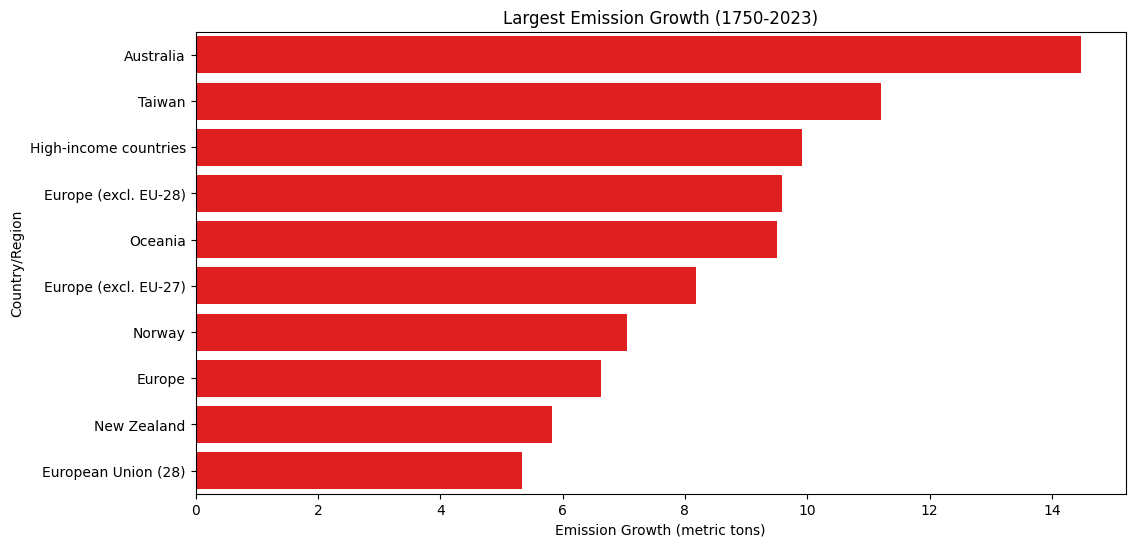

In [5]:
plot_growth_analysis()

In [6]:
def continental_comparison():
    query = """
    SELECT 
        CASE 
            WHEN area ILIKE '%%Asia%%' THEN 'Asia'
            WHEN area ILIKE '%%Europe%%' THEN 'Europe'
            WHEN area ILIKE '%%America%%' THEN 'America'
            ELSE 'Other'
        END AS continent,
        AVG(co2_emissions_per_capita) AS avg_emission
    FROM carbon_emissions
    WHERE year = 2023
    GROUP BY continent;
    """
    df = pd.read_sql_query(query, conn)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='continent', y='avg_emission',color='red')
    plt.title('2023 CO2 Emissions by Continent')
    plt.xlabel('Continent')
    plt.ylabel('Average Emissions (metric tons)')
    plt.show()

C:\Users\aryam\AppData\Local\Temp\ipykernel_46144\3166965312.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


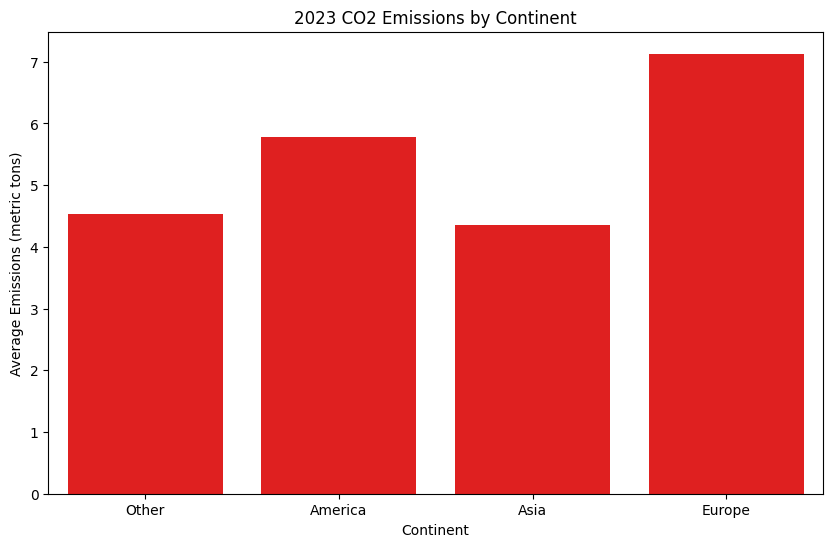

In [7]:
continental_comparison()

C:\Users\aryam\AppData\Local\Temp\ipykernel_46144\700808171.py:19: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



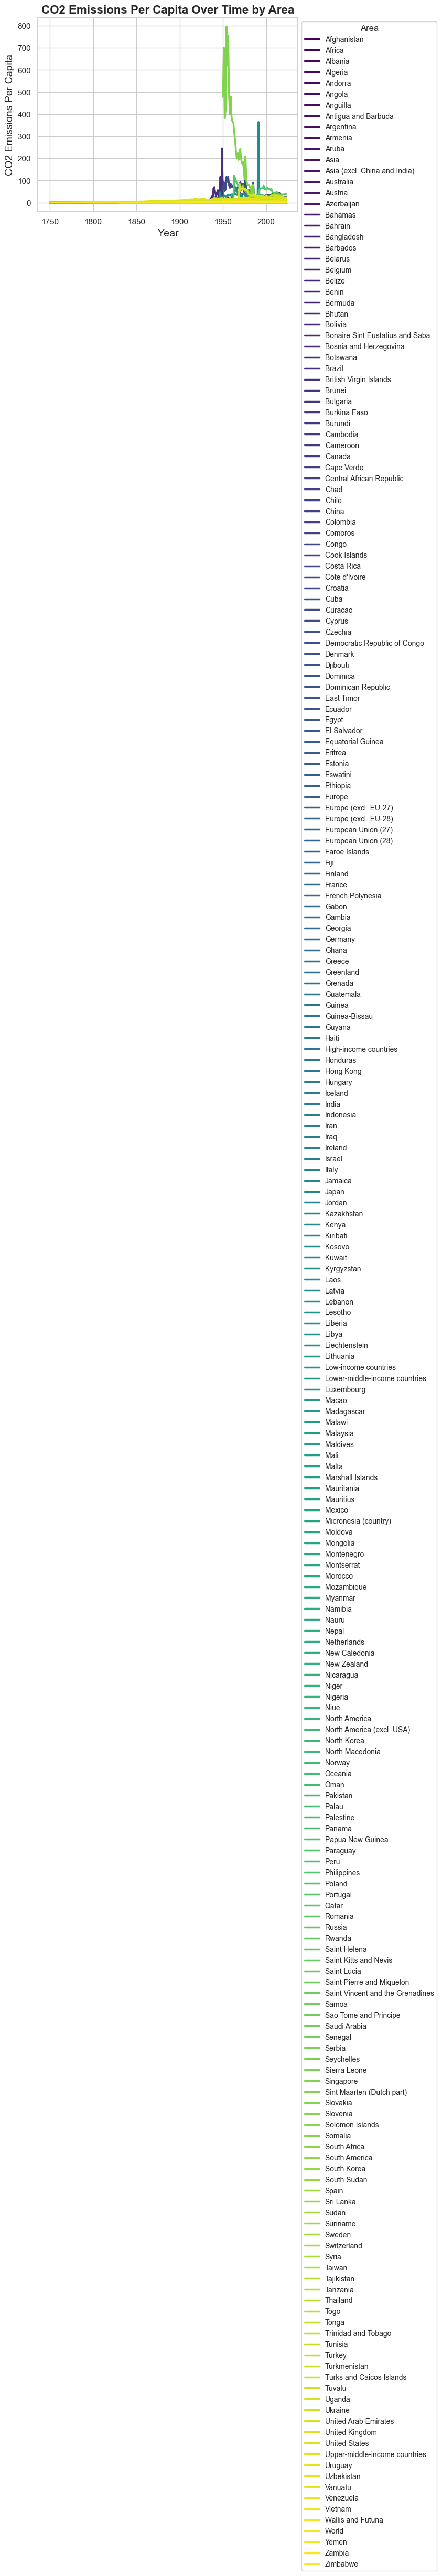

In [16]:
sns.set_theme(style="whitegrid")
 
sns.lineplot(
    data=emissions_df,
    x='year',
    y='co2_emissions_per_capita',
    hue='area',
    palette='viridis',  
    linewidth=2.5       
)
 
plt.title("CO2 Emissions Per Capita Over Time by Area", fontsize=16, fontweight='bold')
 
plt.xlabel("Year", fontsize=14)
plt.ylabel("CO2 Emissions Per Capita", fontsize=14)
 
plt.legend(title="Area", title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
 
plt.tight_layout()
 
plt.show()

### Renewable Energy Analysis

In [17]:
def renewable_energy_eda():
    query = """
        SELECT 
            area, 
            year, 
            renewable_energy_share
        FROM renewable_energy
    """
    renewable_df = fetch_data(query, conn)
    
    if renewable_df is None or renewable_df.empty:
        print("No data available for renewable energy analysis.")
        return

    print("Data Overview")
    display(renewable_df.head())
    print("\nData Info:")
    print(renewable_df.info())
    print("\nMissing Values:")
    print(renewable_df.isnull().sum())

    # Summary of statistics
    print("\n Summary Statistics")
    display(renewable_df.describe())

    # Trend analysis
    print("\n Trend Analysis")
    fig = px.line(
        renewable_df, 
        x='year', 
        y='renewable_energy_share', 
        color='area', 
        title="Renewable Energy Share Over Time by Area",
        labels={'renewable_energy_share': 'Renewable Energy Share (%)', 'year': 'Year'},
        template='plotly_white'
    )
    fig.update_layout(
        title_font=dict(size=20, family='Arial', color='black'),
        legend_title=dict(text='Area'),
        xaxis_title_font=dict(size=14),
        yaxis_title_font=dict(size=14),
        legend=dict(orientation='h', yanchor='bottom', y=-0.3, xanchor='center', x=0.5)
    )
    fig.show()

    # Top and bottom performers
    print("\n Top and Bottom Performers")
    latest_year = renewable_df['year'].max()
    latest_data = renewable_df[renewable_df['year'] == latest_year]
    top_performers = latest_data.nlargest(10, 'renewable_energy_share')
    bottom_performers = latest_data.nsmallest(10, 'renewable_energy_share')
    print(f"\nTop 10 Performers in {latest_year}:")
    display(top_performers)
    print(f"\nBottom 10 Performers in {latest_year}:")
    display(bottom_performers)

    # Visualization for top and bottom performers
    fig_top = px.bar(
        top_performers, 
        x='renewable_energy_share', 
        y='area', 
        orientation='h', 
        title=f"Top 10 Areas by Renewable Energy Share in {latest_year}",
        labels={'renewable_energy_share': 'Renewable Energy Share (%)', 'area': 'Area'},
        template='plotly_white'
    )
    fig_top.update_layout(
        title_font=dict(size=20),
        xaxis_title_font=dict(size=14),
        yaxis_title_font=dict(size=14),
        coloraxis_colorbar=dict(
            title="Renewable Energy Share",
            title_font=dict(size=12),
            tickfont=dict(size=10)
        )
    )
    fig_top.update_traces(marker=dict(color='rgba(0, 128, 128, 0.8)', line=dict(color='rgba(0, 128, 128, 1)', width=1)))
    fig_top.show()

    fig_bottom = px.bar(
        bottom_performers, 
        x='renewable_energy_share', 
        y='area', 
        orientation='h', 
        title=f"Bottom 10 Areas by Renewable Energy Share in {latest_year}",
        labels={'renewable_energy_share': 'Renewable Energy Share (%)', 'area': 'Area'},
        template='plotly_white'
    )
    fig_bottom.update_layout(
        title_font=dict(size=20),
        xaxis_title_font=dict(size=14),
        yaxis_title_font=dict(size=14)
    )
    fig_bottom.show()

    # Growth Rate Analysis
    print("\n Growth Rate Analysis")
    growth_query = """
        WITH start AS (
            SELECT area, renewable_energy_share AS start_share
            FROM renewable_energy
            WHERE year = (SELECT MIN(year) FROM renewable_energy)
        ),
        end_data AS (
            SELECT area, renewable_energy_share AS end_share
            FROM renewable_energy
            WHERE year = (SELECT MAX(year) FROM renewable_energy)
        )
        SELECT s.area, 
               (e.end_share - s.start_share) AS absolute_growth,
               CASE 
                   WHEN s.start_share > 0 THEN ((e.end_share - s.start_share) / s.start_share)
                   ELSE NULL
               END AS relative_growth
        FROM start s
        JOIN end_data e ON s.area = e.area
        ORDER BY absolute_growth DESC
        LIMIT 10;
    """
    growth_df = fetch_data(growth_query, conn)
    print("\nTop 10 Areas by Absolute Growth:")
    display(growth_df)

    # Visualization for growth
    fig_growth = px.bar(
        growth_df, 
        x='absolute_growth', 
        y='area', 
        orientation='h', 
        title="Top 10 Areas by Renewable Energy Growth",
        labels={'absolute_growth': 'Absolute Growth (%)', 'area': 'Area'},
        template='plotly_white',
        color='absolute_growth',
        color_continuous_scale=px.colors.sequential.Viridis
    )
    fig_growth.update_layout(
        title_font=dict(size=20),
        xaxis_title_font=dict(size=14),
        yaxis_title_font=dict(size=14)
    )
    fig_growth.show()


renewable_energy_eda()

Data Overview


C:\Users\aryam\AppData\Local\Temp\ipykernel_46144\3065636406.py:15: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,area,year,renewable_energy_share
0,Africa,1965,5.740281
1,Africa,1966,6.113969
2,Africa,1967,6.316580
3,Africa,1968,6.994845
4,Africa,1969,7.943916



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4903 entries, 0 to 4902
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   area                    4903 non-null   object 
 1   year                    4903 non-null   int64  
 2   renewable_energy_share  4903 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 115.0+ KB
None

Missing Values:
area                      0
year                      0
renewable_energy_share    0
dtype: int64

 Summary Statistics


,year,renewable_energy_share
count,4903.000000,4903.000000
mean,1996.238629,11.253916
std,16.455328,11.890442
min,1965.000000,0.000000
25%,1983.000000,3.388088
50%,1997.000000,7.060916
75%,2010.000000,15.021350
max,2023.000000,74.301690



 Trend Analysis



 Top and Bottom Performers

Top 10 Performers in 2023:


,area,year,renewable_energy_share
3254,Norway,2023,72.091100
4181,Sweden,2023,53.890182
720,Brazil,2023,50.331410
1261,Denmark,2023,42.734860
3003,New Zealand,2023,42.266953
471,Austria,2023,40.080193
3989,South America,2023,38.354640
4237,Switzerland,2023,38.325344
1319,Eastern Africa (EI),2023,36.207233
3613,Portugal,2023,36.043410



Bottom 10 Performers in 2023:


,area,year,renewable_energy_share
4353,Trinidad and Tobago,2023,0.009917
176,Algeria,2023,0.270369
3770,Saudi Arabia,2023,0.465171
1918,Hong Kong,2023,0.938085
563,Bangladesh,2023,1.008031
602,Belarus,2023,1.095596
2831,Middle East (EI),2023,1.601705
2155,Iran,2023,1.822921
510,Azerbaijan,2023,2.321686
4682,Uzbekistan,2023,3.251392



 Growth Rate Analysis

Top 10 Areas by Absolute Growth:


C:\Users\aryam\AppData\Local\Temp\ipykernel_46144\3065636406.py:15: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,area,absolute_growth,relative_growth
0,South America,27.403708,2.502409
1,South and Central America (EI),25.785670,2.684746
2,Brazil,22.782685,0.826996
3,Germany,22.779698,14.109417
4,Venezuela,22.123338,10.464817
5,Romania,20.787356,19.496334
6,United Kingdom,19.931810,33.852315
7,Colombia,18.187907,1.695203
8,Netherlands,17.788414,NaN
9,Europe (EI),15.660856,2.160930


### Correlation between CO2 Emissions Per Capita and Renewable Share

In [10]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

query_emissions = """
    SELECT 
        area, 
        year, 
        co2_emissions_per_capita
    FROM carbon_emissions
"""

query_renewable = """
    SELECT 
        area, 
        year, 
        renewable_energy_share
    FROM renewable_energy
"""

emissions_df = fetch_data(query_emissions, conn)
renewable_df = fetch_data(query_renewable, conn)

if emissions_df is not None and renewable_df is not None:
    combined_df = pd.merge(emissions_df, renewable_df, on=['area', 'year'], how='inner')
    
    correlation = combined_df['co2_emissions_per_capita'].corr(combined_df['renewable_energy_share'])
    print(f"Correlation between CO2 Emissions Per Capita and Renewable Share: {correlation:.2f}")

    fig = px.scatter(
        combined_df,
        x='renewable_energy_share',
        y='co2_emissions_per_capita',
        color='area',
        hover_data=['year'],
        title='<b>CO2 Emissions Per Capita vs Renewable Energy Share by Area</b>',
        labels={
            'renewable_energy_share': 'Renewable Share (%)',
            'co2_emissions_per_capita': 'CO2 Emissions Per Capita'
        },
        color_discrete_sequence=px.colors.qualitative.Plotly,
        template='plotly_white'
    )

   
    fig.add_annotation(
        x=0.95,
        y=0.95,
        xref='paper',
        yref='paper',
        text=f'Correlation: {correlation:.2f}',
        showarrow=False,
        font=dict(size=14)
    )
    
    fig.update_layout(
        width=1200,
        height=600,
        legend=dict(
            title=dict(text='Area'),
            orientation='v',
            yanchor='top',
            y=0.8,
            xanchor='left',
            x=1.02
        ),
        margin=dict(r=150),
        title_font=dict(size=24),
        xaxis_title_font=dict(size=16),
        yaxis_title_font=dict(size=16)
    )

    fig.show()
    
else:
    print("Data could not be fetched or merged.")

C:\Users\aryam\AppData\Local\Temp\ipykernel_46144\3065636406.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Correlation between CO2 Emissions Per Capita and Renewable Share: -0.21


### Life Expectancy Analysis

In [11]:
def life_expectancy_eda():
    query = """
        SELECT 
            area, 
            year, 
            life_expectancy
        FROM life_expectancy
    """
    life_expectancy_df = fetch_data(query, conn)
    
    if life_expectancy_df is None or life_expectancy_df.empty:
        print("No data available for life expectancy analysis.")
        return

    print("Data Overview")
    display(life_expectancy_df.head())
    print("\nData Info:")
    print(life_expectancy_df.info())
    print("\nMissing Values:")
    print(life_expectancy_df.isnull().sum())

    print("\n Summary Statistics")
    display(life_expectancy_df.describe())

    print("\n Trend Analysis")
    fig = px.line(
        life_expectancy_df, 
        x='year', 
        y='life_expectancy', 
        color='area', 
        title="Life Expectancy Over Time by Area",
        labels={'life_expectancy': 'Life Expectancy (Years)', 'year': 'Year'},
        template='plotly_white'
    )
    fig.update_layout(
        title_font=dict(size=20, family='Arial', color='black'),
        legend_title=dict(text='Area'),
        xaxis_title_font=dict(size=14),
        yaxis_title_font=dict(size=14),
        legend=dict(orientation='h', yanchor='bottom', y=-0.3, xanchor='center', x=0.5)
    )
    fig.show()

    print("\n Top and Bottom Performers")
    latest_year = life_expectancy_df['year'].max()
    latest_data = life_expectancy_df[life_expectancy_df['year'] == latest_year]
    top_performers = latest_data.nlargest(10, 'life_expectancy')
    bottom_performers = latest_data.nsmallest(10, 'life_expectancy')
    print(f"\nTop 10 Performers in {latest_year}:")
    display(top_performers)
    print(f"\nBottom 10 Performers in {latest_year}:")
    display(bottom_performers)

    fig_top = px.bar(
        top_performers, 
        x='life_expectancy', 
        y='area', 
        orientation='h', 
        title=f"Top 10 Areas by Life Expectancy in {latest_year}",
        labels={'life_expectancy': 'Life Expectancy (Years)', 'area': 'Area'},
        template='plotly_white',
        color_discrete_sequence=['#2ECC71']
    )
    fig_top.update_layout(
        title_font=dict(size=20),
        xaxis_title_font=dict(size=14),
        yaxis_title_font=dict(size=14)
    )
    fig_top.show()

    fig_bottom = px.bar(
        bottom_performers, 
        x='life_expectancy', 
        y='area', 
        orientation='h', 
        title=f"Bottom 10 Areas by Life Expectancy in {latest_year}",
        labels={'life_expectancy': 'Life Expectancy (Years)', 'area': 'Area'},
        template='plotly_white',
        color_discrete_sequence=['#FF6F61']  
    )
    fig_bottom.update_layout(
        title_font=dict(size=20),
        xaxis_title_font=dict(size=14),
        yaxis_title_font=dict(size=14)
    )
    fig_bottom.show()

life_expectancy_eda()

Data Overview


C:\Users\aryam\AppData\Local\Temp\ipykernel_46144\3065636406.py:15: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,area,year,life_expectancy
0,Afghanistan,1950,28.1563
1,Afghanistan,1951,28.5836
2,Afghanistan,1952,29.0138
3,Afghanistan,1953,29.4521
4,Afghanistan,1954,29.6975



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21565 entries, 0 to 21564
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area             21565 non-null  object 
 1   year             21565 non-null  int64  
 2   life_expectancy  21565 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 505.6+ KB
None

Missing Values:
area               0
year               0
life_expectancy    0
dtype: int64

 Summary Statistics


,year,life_expectancy
count,21565.000000,21565.000000
mean,1976.992812,61.942238
std,38.461606,12.925909
min,1543.000000,10.989100
25%,1962.000000,52.703000
50%,1982.000000,64.479900
75%,2003.000000,71.978900
max,2023.000000,86.372400



 Trend Analysis



 Top and Bottom Performers

Top 10 Performers in 2023:


,area,year,life_expectancy
12788,Monaco,2023,86.3724
16791,San Marino,2023,85.7062
8221,Hong Kong,2023,85.5106
9415,Japan,2023,84.7123
18011,South Korea,2023,84.3288
16199,Saint Barthelemy,2023,84.2901
6630,French Polynesia,2023,84.0698
528,Andorra,2023,84.0406
18855,Switzerland,2023,83.9536
1172,Australia,2023,83.9228



Bottom 10 Performers in 2023:


,area,year,life_expectancy
14080,Nigeria,2023,54.4623
3500,Chad,2023,55.0692
10539,Lesotho,2023,57.3749
3426,Central African Republic,2023,57.4077
18085,South Sudan,2023,57.6174
17855,Somalia,2023,58.8158
11922,Mali,2023,60.4394
7697,Guinea,2023,60.7405
2032,Benin,2023,60.7738
2868,Burkina Faso,2023,61.0920


### Combined Data Analysis

In [12]:
def fetch_joined_data():
    query = """
    SELECT 
        ce.area,
        ce.year,
        ce.co2_emissions_per_capita,
        re.renewable_energy_share,
        le.life_expectancy
    FROM carbon_emissions ce
    JOIN renewable_energy re 
        ON ce.area = re.area AND ce.year = re.year
    JOIN life_expectancy le 
        ON ce.area = le.area AND ce.year = le.year
    """
    return pd.read_sql_query(query, conn)

df = fetch_joined_data()

C:\Users\aryam\AppData\Local\Temp\ipykernel_46144\191202240.py:15: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [13]:
fig = px.scatter(df, 
                 x='co2_emissions_per_capita', 
                 y='life_expectancy',
                 color='area',
                 title='CO2 Emissions vs. Life Expectancy',
                 labels={'co2_emissions_per_capita':'CO2 Emissions (tons)', 'life_expectancy':'Life Expectancy'},
                 hover_data=['year'])
fig.show()

In [ ]:
if 'df' not in globals():
    def fetch_joined_data():
        query = """
        SELECT 
            ce.area,
            ce.year,
            ce.co2_emissions_per_capita,
            re.renewable_energy_share,
            le.life_expectancy
        FROM carbon_emissions ce
        JOIN renewable_energy re 
            ON ce.area = re.area AND ce.year = re.year
        JOIN life_expectancy le 
            ON ce.area = le.area AND ce.year = le.year
        """
        return pd.read_sql_query(query, conn)

    df = fetch_joined_data()

fig = px.scatter(
    df,
    x='renewable_energy_share',
    y='life_expectancy',
    color='area',
    title='Renewable Energy Share vs. Life Expectancy',
    labels={'renewable_energy_share': 'Renewable Energy Share (%)', 'life_expectancy': 'Life Expectancy (years)'},
    hover_data=['year']
)
fig.show()

In [14]:
fig = px.scatter_3d(
    df,
    x='co2_emissions_per_capita',
    y='renewable_energy_share',
    z='life_expectancy',
    color='area',
    title='3D Analysis: CO2 Emissions, Renewable Energy, and Life Expectancy',
    labels={
        'co2_emissions_per_capita': 'CO2 Emissions (tons)',
        'renewable_energy_share': 'Renewable Energy Share (%)',
        'life_expectancy': 'Life Expectancy (years)'
    },
    hover_data=['year']
)
fig.update_layout(
    width=1000,  
    height=800   
)
fig.show()

In [ ]:
latest_year = df['year'].max()
df_latest = df[df['year'] == latest_year]

fig = px.choropleth(df_latest,
                    locations='area',
                    locationmode='country names',
                    color='co2_emissions_per_capita',
                    hover_name='area',
                    title=f'CO2 Emissions per Capita ({latest_year})',
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [15]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])

corr_matrix = df_numeric.corr()

fig = px.imshow(corr_matrix,
                labels=dict(x='Features', y='Features', color='Correlation'),
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                color_continuous_scale=px.colors.diverging.RdBu_r,
                title='Feature Correlation Matrix')
fig.show()

### Closing PostgreSQL Connection

In [ ]:
conn.close()
print("PostgreSQL connection closed.")

PostgreSQL connection closed.
